In [2]:
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the dictionary from the file
path_to_read = '/Users/luisescobar/Documents/Thesis/DataSets/Dictionary'
path_to_save = '/Users/luisescobar/Documents/Thesis/DataSets/Dictionary'
file_name = 'completo1007_(edit).pkl'
name_to_read = f'{path_to_read}/{file_name}'

with open(name_to_read, 'rb') as file:
    loaded_dict = pickle.load(file)


In [3]:
loaded_dict.keys()

dict_keys(['df_801', 'df_802', 'df_803', 'df_806', 'df_807', 'df_808', 'df_809', 'df_810', 'df_811', 'df_812', 'df_813', 'df_814', 'df_815', 'df_816', 'df_817', 'df_818', 'df_819', 'df_820', 'df_821', 'df_822', 'df_823', 'df_824', 'df_825', 'df_826', 'df_827', 'df_828', 'df_829', 'df_830', 'df_831', 'df_832', 'df_833', 'df_834', 'df_835', 'df_836', 'df_839', 'df_840', 'df_841', 'df_842', 'df_843', 'df_844', 'df_845', 'df_846', 'df_849', 'df_850', 'df_851', 'df_853', 'df_854', 'df_855', 'df_856', 'df_857', 'df_858', 'df_859', 'df_860', 'df_861', 'df_862', 'df_863', 'df_868', 'df_869', 'df_870', 'df_871', 'df_872', 'df_873', 'df_874', 'df_875', 'df_876', 'df_877', 'df_878', 'df_879', 'df_880', 'df_881', 'df_882', 'df_883', 'df_884', 'df_885', 'df_886', 'df_887', 'df_888', 'df_889', 'df_891', 'df_892', 'df_893', 'df_894', 'df_895', 'df_896', 'df_897', 'df_898', 'df_899', 'df_900', 'df_901', 'df_902', 'df_903', 'df_904', 'df_905', 'df_906', 'df_907', 'df_908', 'df_909', 'df_910', 'df_914',

In [4]:
def handle_case(case):
    '''The function returns the threshold value associated
    with the selected filter 
    Parameters
    ----------
    case : string 
        String with the name of the filter used in the current treatment

        
    Returns
    -------
    case : int
        Integer value associated to the threshold of the current
        filter
    '''
    
    cases = {
        'septeX':  450,
        'ST150':   450,
        'oXiris':  450,
        'TPE2000': 500,
        'X-MARS':  600,
        'M100':    450,
        'ST60':    450,
        'HF1000':  500,
        'ST100':   450,
        'HF1400':  500
    }
    return cases.get(case, "Case not found")

In [5]:
def Delta_P_ref(index, df_test):
    '''The function returns the Delta P reference value. Takes an index and
    computes the median of iloc[index:index + 9] over DeltaP column
    Parameters
    ----------
    index : int 
        String index to compute the reference value 

    df_test : pandas.core.frame.DataFrame
        Data Frame which includes the column 'DeltaP'
        
    Returns
    -------
    reference : int
        Delta P reference value 
    '''
    reference = df_test['DeltaP'].iloc[index:index + 9].median()
    return reference

def TMP_ref(index, df_test):
    '''The function returns the TMP reference value. Takes an index and
    computes the median of iloc[index:index + 9] over TMP column
    Parameters
    ----------
    index : int 
        String index to compute the reference value 

    df_test : pandas.core.frame.DataFrame
        Data Frame which includes the column 'TMP'
        
    Returns
    -------
    reference : int
        TMP reference value 
    '''
    reference = df_test['TMP'].iloc[index:index + 9].median()
    return reference



Verify that the following cell produces the correct output

In [6]:
prescription_cols = ['Q_Blood_Pump', 'Q_Replacement', 'Q_Dialysate', 'Q_PBP', 'Q_Patient_Fluid_Removal']

for name, df_test in loaded_dict.items():
    df_test = df_test.reset_index(drop=True)
    
    # Initial Setup
    df_length = len(df_test)
    initial_index = 10
    
    # Precompute reference values for the first 10 rows
    Q_val_set = df_test.loc[0, prescription_cols]
    Delta_P_ref_loop = Delta_P_ref(0, df_test)
    TMP_ref_loop = TMP_ref(0, df_test)
    
    # Initialize the condition and reference columns
    df_test['Condition_1'] = False
    df_test['Condition_2'] = False
    df_test['Delta_P_ref'] = np.nan
    df_test['TMP_ref'] = np.nan
    
    # Vectorized array to hold filter values
    filter_values = df_test['Set'].apply(handle_case).values
    
    # Set initial reference values for the first 10 rows
    df_test.loc[0:9, 'Delta_P_ref'] = Delta_P_ref_loop
    df_test.loc[0:9, 'TMP_ref'] = TMP_ref_loop
    
    # Iterate through DataFrame starting from row 10
    i = initial_index
    while i < df_length:
        # Identify block of rows with unchanged prescription values
        current_prescription = df_test.loc[i, prescription_cols]
        block_end = df_test[i:].index[~(df_test.loc[i:, prescription_cols] == current_prescription).all(axis=1)].min()
        block_end = block_end if pd.notna(block_end) else df_length

        # Calculate the conditions for the block
        condition_1 = df_test.loc[i:block_end-1, 'DeltaP'] > (Delta_P_ref_loop + 100)
        condition_2 = (df_test.loc[i:block_end-1, 'P_Filter'] >= 450) & (TMP_ref_loop > filter_values[i:block_end])

        # Apply the conditions and reference values to the DataFrame
        df_test.loc[i:block_end-1, 'Condition_1'] = condition_1.values
        df_test.loc[i:block_end-1, 'Condition_2'] = condition_2.values
        df_test.loc[i:block_end-1, 'Delta_P_ref'] = Delta_P_ref_loop + 100
        df_test.loc[i:block_end-1, 'TMP_ref'] = TMP_ref_loop

        # Update references if prescription values changed
        Delta_P_ref_loop = Delta_P_ref(block_end - 1, df_test)
        TMP_ref_loop = TMP_ref(block_end - 1, df_test)
        
        # Move to the next block
        i = block_end

    # Final vectorized calculation for clotting
    df_test['Clotting_1'] = df_test['Condition_1'] | df_test['Condition_2']

    # Initialize Clotting_2 column with zeros 
    df_test['Clotting_2'] = 0
    
    # Step 1: Identify runs of consecutive 1s
    df_test['group'] = (df_test['Clotting_1'] != df_test['Clotting_1'].shift()).cumsum() * df_test['Clotting_1']
    
    # Step 2: Count the size of each group
    group_sizes = df_test['group'].map(df_test['group'].value_counts())
    
    # Step 3: Assign 1 to sequences longer than 2
    df_test['Clotting_2'] = np.where((df_test['Clotting_1'] == 1) & (group_sizes > 2), 1, 0)
    
    # Drop the helper column if needed
    #df.drop(columns='group', inplace=True)


    loaded_dict[name] = df_test


In [7]:
# Compute percentage of cases 
classes_1 = []
classes_2 = []
for name, df in loaded_dict.items():
    if (df['Clotting_1'] == 1).any():
        classes_1.append(1)
    else:
        classes_1.append(0)
        
    if (df['Clotting_2'] == 1).any():
        classes_2.append(1)
    else:
        classes_2.append(0)
    

In [8]:
sum(classes_1)/len(classes_1)

0.1945945945945946

In [9]:
sum(classes_2)/len(classes_2)

0.14594594594594595

In [10]:
len(classes_1)

185

In [11]:
# Save updated dictionary
file_no_ext = os.path.splitext(file_name)[0]
name_save = f'{path_to_save}/{file_no_ext}_clotting.pkl' 
with open(name_save, 'wb') as file:
    pickle.dump(loaded_dict, file)

Plots of some results. We have two reference values; one for TMP and one for Delta P

In [12]:
df_test_bug = loaded_dict['df_802']
df_test_bug = df_test_bug.reset_index(drop=True)
#df_test_bug.head()

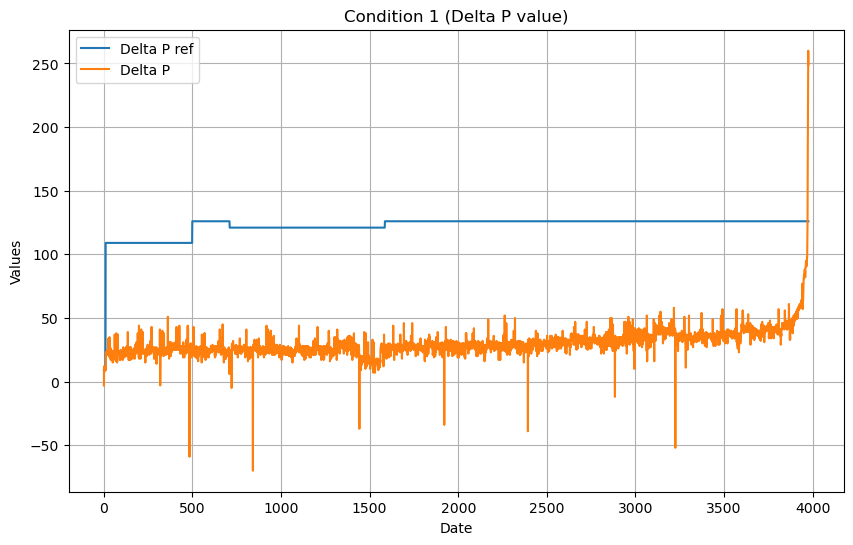

In [13]:
# Plotting the two columns
plt.figure(figsize=(10, 6))
plt.plot(df_test_bug.index, df_test_bug['Delta_P_ref'], label='Delta P ref')
plt.plot(df_test_bug.index, df_test_bug['DeltaP'], label='Delta P')


plt.title('Condition 1 (Delta P value)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

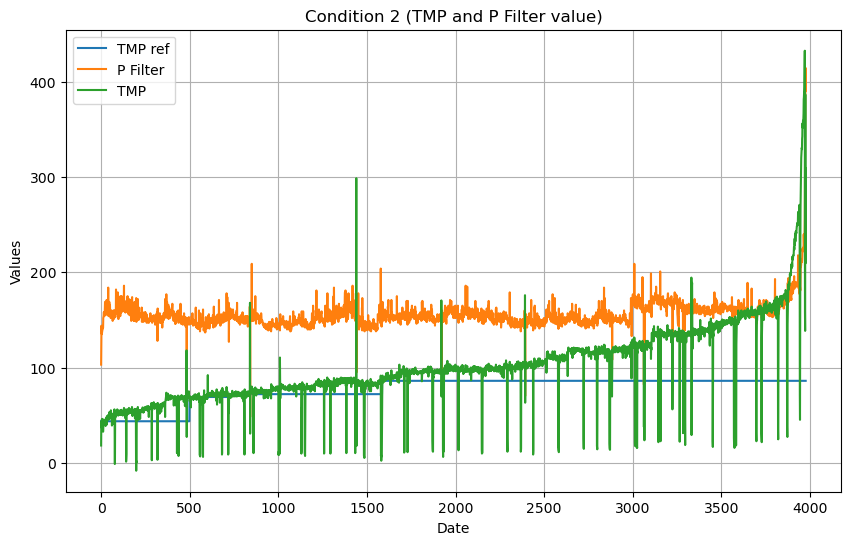

In [14]:
# Plotting the two columns
plt.figure(figsize=(10, 6))

plt.plot(df_test_bug.index, df_test_bug['TMP_ref'], label='TMP ref')
plt.plot(df_test_bug.index, df_test_bug['P_Filter'], label='P Filter ')
#plt.axhline(y=450, color='red', linestyle='--', label='P Filter reference')
plt.plot(df_test_bug.index, df_test_bug['TMP'], label='TMP')


plt.title('Condition 2 (TMP and P Filter value)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

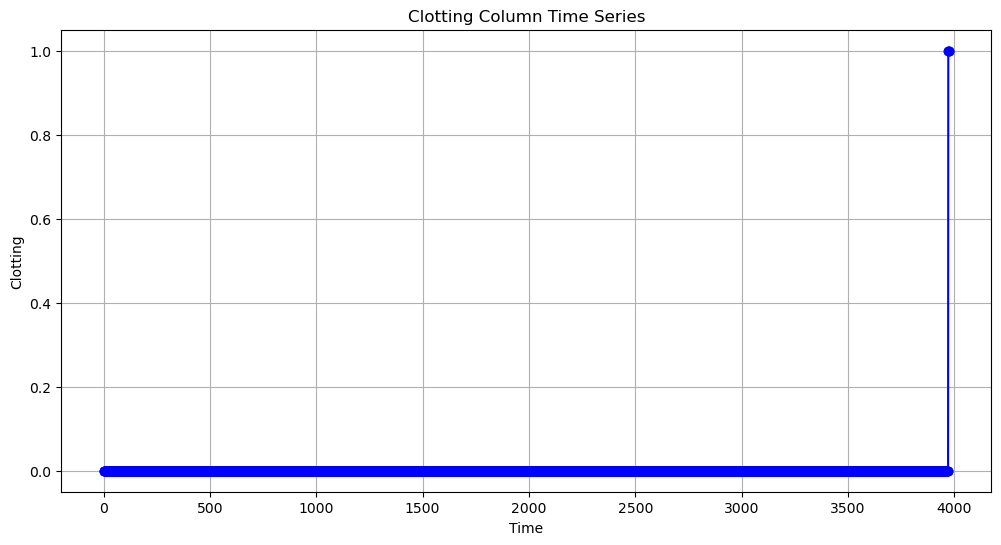

In [15]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_test_bug.index, df_test_bug['Clotting_1'], marker='o', linestyle='-', color='b')
plt.title('Clotting Column Time Series')
plt.xlabel('Time')
plt.ylabel('Clotting')
plt.grid(True)
plt.show()

In [16]:
df_test_bug.tail(10)

,Date__Heure,P_Access,P_Filter,P_Effluent,P_Return,Q_Blood_Pump,Q_Replacement,Q_Dialysate,Q_PBP,Q_Patient_Fluid_Removal,...,trt,Patient_weight__Kg_,Set,Condition_1,Condition_2,Delta_P_ref,TMP_ref,Clotting_1,Clotting_2,group
3967,2011-08-30 04:11:00,-62,229,-236,113,150,2400,0,0,150,...,802,80.0,ST150,False,False,126.0,86.0,False,0,0
3968,2011-08-30 04:12:00,-54,230,-238,107,150,2400,0,0,150,...,802,80.0,ST150,False,False,126.0,86.0,False,0,0
3969,2011-08-30 04:13:00,-54,233,-241,110,150,2400,0,0,150,...,802,80.0,ST150,False,False,126.0,86.0,False,0,0
3970,2011-08-30 04:14:00,-49,241,-255,104,150,2400,0,0,150,...,802,80.0,ST150,False,False,126.0,86.0,False,0,0
3971,2011-08-30 04:15:00,-37,256,-270,106,150,2400,0,0,150,...,802,80.0,ST150,False,False,126.0,86.0,False,0,0
3972,2011-08-30 04:16:00,-35,314,40,118,150,2400,0,0,150,...,802,80.0,ST150,True,False,126.0,86.0,True,1,2
3973,2011-08-30 04:17:00,-37,345,76,120,150,2400,0,0,150,...,802,80.0,ST150,True,False,126.0,86.0,True,1,2
3974,2011-08-30 04:18:00,-38,363,-169,109,150,2400,0,0,150,...,802,80.0,ST150,True,False,126.0,86.0,True,1,2
3975,2011-08-30 04:19:00,-30,415,45,130,150,2400,0,0,150,...,802,80.0,ST150,True,False,126.0,86.0,True,1,2
3976,2011-08-30 04:20:00,-30,391,-73,117,150,2400,0,0,150,...,802,80.0,ST150,True,False,126.0,86.0,True,1,2


We have some series in which the duration of the treatment is very short. Should we use them? Do they provide useful information to the model?

In [20]:
for name, df in loaded_dict.items():
    if len(df)<60:
        print(f'{name} -----> {len(df)}')

df_803 -----> 21
df_815 -----> 21
df_922 -----> 13
df_927 -----> 24
df_942 -----> 1
df_949 -----> 40
df_976 -----> 9
df_977 -----> 9
df_993 -----> 40
